In [1]:
import pandas as pd
import psycopg2
import os
from dotenv import load_dotenv
import numpy as np

import pandas as pd
from geopy.distance import geodesic
import math
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import plotly.express as px
from scipy.stats import linregress
import statsmodels.api as sm

In [2]:
load_dotenv()

DATABASE = os.getenv('DATABASE')
USER_DB = os.getenv('USER_DB')
PASSWORD = os.getenv('PASSWORD')
HOST = os.getenv('HOST')
PORT = os.getenv('PORT')

conn = psycopg2.connect(
    database=DATABASE,
    user=USER_DB,
    password=PASSWORD,
    host=HOST,
    port=PORT
)


query_string = "SELECT * FROM  eda.king_county_house_details d JOIN eda.king_county_house_sales s  ON s.house_id = d.id"
df_psycopg = pd.read_sql(query_string, conn)



/var/folders/lk/gq8wby6x3fv6n16s31xl4dg00000gn/T/ipykernel_1664/1991793502.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_psycopg = pd.read_sql(query_string, conn)


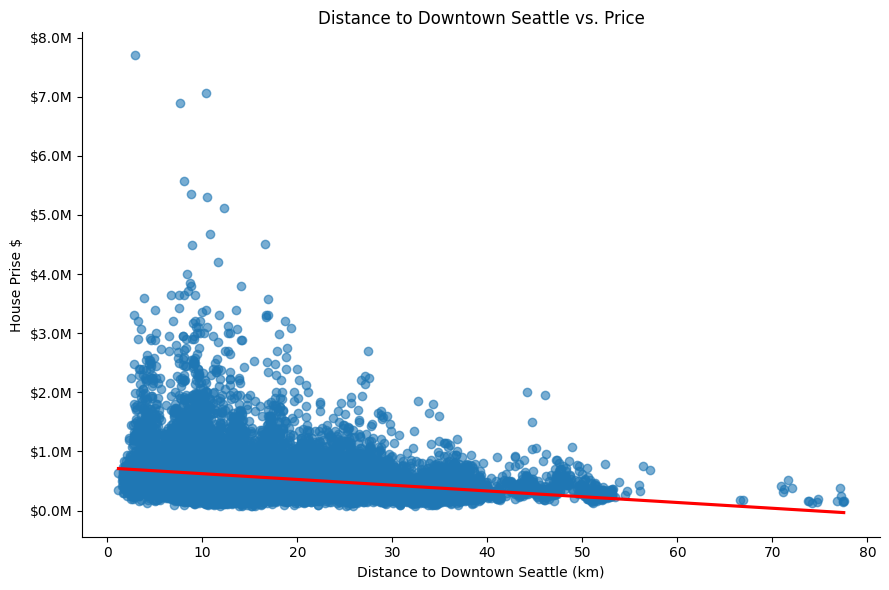

In [3]:
downtown_lat = 47.6050242
downtown_lon = -122.3343709 

df_psycopg['distance_to_downtown'] = df_psycopg.apply(
    lambda row: geodesic(
        (row['lat'], row['long']),
        (47.6050242, -122.3343709)
    ).km,
    axis=1
)

g = sns.lmplot(
    data=df_psycopg,
    x='distance_to_downtown',
    y='price',
    height=6,
    aspect=1.5,
    scatter_kws={'alpha':0.6},
    line_kws={'color':'red'}
)
ax = g.axes[0,0]

# Formatter für Preis in Millionen $
formatter = FuncFormatter(lambda x, _: f'${x/1e6:.1f}M')
ax.yaxis.set_major_formatter(formatter)

# Achsentitel usw.
ax.set_title('Distance to Downtown Seattle vs. Price')
ax.set_xlabel('Distance to Downtown Seattle (km)')
ax.set_ylabel('House Prise $')

plt.tight_layout()
plt.show()
#

/var/folders/lk/gq8wby6x3fv6n16s31xl4dg00000gn/T/ipykernel_1664/3931912770.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_psycopg.groupby('distance_bin')


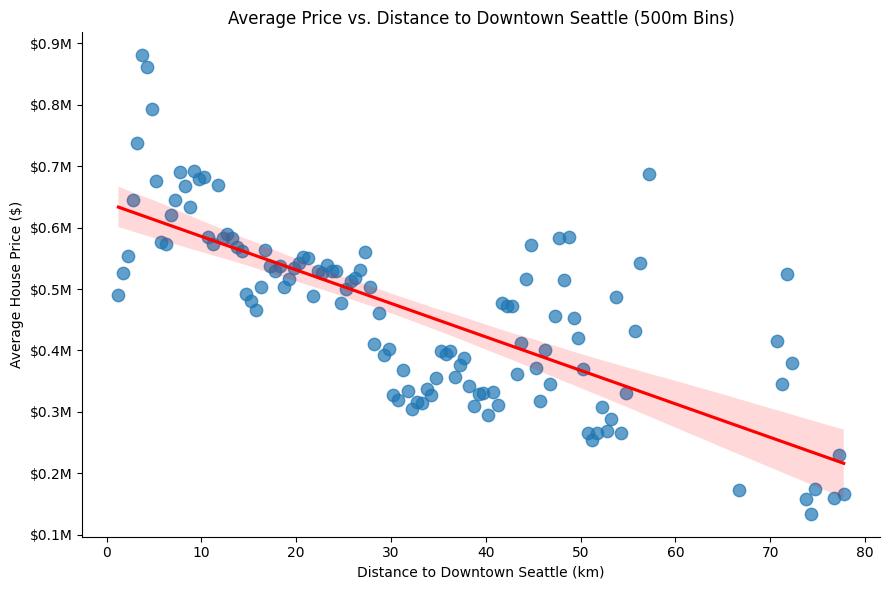

In [4]:
bin_edges = np.arange(
    0,
    df_psycopg['distance_to_downtown'].max() + 0.5,
    0.5
)

# Bin-Zuweisung
df_psycopg['distance_bin'] = pd.cut(
    df_psycopg['distance_to_downtown'],
    bins=bin_edges,
    include_lowest=True,
    right=False
)

df_bins = (
    df_psycopg.groupby('distance_bin')
    .agg({
        'price': 'mean'
    })
    .reset_index()
)

# Midpoint jeder Bin berechnen
df_bins['distance_mid'] = df_bins['distance_bin'].apply(lambda x: (x.left + x.right) / 2)

g = sns.lmplot(
    data=df_bins,
    x='distance_mid',
    y='price',
    height=6,
    aspect=1.5,
    scatter_kws={'s': 80, 'alpha': 0.7},
    line_kws={'color': 'red'}
)

ax = g.axes[0,0]

# Preis in Millionen-Format
formatter = FuncFormatter(lambda x, _: f'${x/1e6:.1f}M')
ax.yaxis.set_major_formatter(formatter)

# Titel & Achsen
ax.set_title('Average Price vs. Distance to Downtown Seattle (500m Bins)')
ax.set_xlabel('Distance to Downtown Seattle (km)')
ax.set_ylabel('Average House Price ($)')

plt.tight_layout()
plt.show()

In [5]:
df_zipcodetable = pd.read_csv('data/uszips.csv')

In [6]:
df_zipcodetable.head()

,zip_join,lat_zipcode,lng_zipcode,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
0,601,18.18027,-66.75266,Adjuntas,PR,Puerto Rico,True,NaN,16721.0,100.2,72001,Adjuntas,"{""72001"": 98.74, ""72141"": 1.26}",Adjuntas|Utuado,72001|72141,False,False,America/Puerto_Rico
1,602,18.36075,-67.17541,Aguada,PR,Puerto Rico,True,NaN,37510.0,477.6,72003,Aguada,"{""72003"": 100}",Aguada,72003,False,False,America/Puerto_Rico
2,603,18.45744,-67.12225,Aguadilla,PR,Puerto Rico,True,NaN,48317.0,543.1,72005,Aguadilla,"{""72005"": 99.76, ""72099"": 0.24}",Aguadilla|Moca,72005|72099,False,False,America/Puerto_Rico
3,606,18.16585,-66.93716,Maricao,PR,Puerto Rico,True,NaN,5435.0,47.3,72093,Maricao,"{""72093"": 82.26, ""72153"": 11.67, ""72121"": 6.06}",Maricao|Yauco|Sabana Grande,72093|72153|72121,False,False,America/Puerto_Rico
4,610,18.29110,-67.12243,Anasco,PR,Puerto Rico,True,NaN,25413.0,264.4,72011,Añasco,"{""72011"": 96.8, ""72099"": 2.83, ""72083"": 0.37}",Añasco|Moca|Las Marías,72011|72099|72083,False,False,America/Puerto_Rico


In [7]:
df_joined = pd.merge(
    df_psycopg,
    df_zipcodetable,
    how='left',
    left_on='zipcode',
    right_on='zip_join'
)

In [8]:
df_joined

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
0,7129300520,3.0,1.00,1180.0,5650.0,1.0,NaN,0.0,3,7,...,25929.0,2042.6,53033,King,"{""53033"": 100}",King,53033,False,False,America/Los_Angeles
1,6414100192,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3,7,...,43807.0,3117.7,53033,King,"{""53033"": 100}",King,53033,False,False,America/Los_Angeles
2,5631500400,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3,6,...,23594.0,1481.9,53033,King,"{""53033"": 100}",King,53033,False,False,America/Los_Angeles
3,2487200875,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5,7,...,17299.0,2910.8,53033,King,"{""53033"": 100}",King,53033,False,False,America/Los_Angeles
4,1954400510,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3,8,...,30850.0,1135.7,53033,King,"{""53033"": 100}",King,53033,False,False,America/Los_Angeles
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,3.0,2.50,1530.0,1131.0,3.0,0.0,0.0,3,8,...,51988.0,4378.3,53033,King,"{""53033"": 100}",King,53033,False,False,America/Los_Angeles
21593,6600060120,4.0,2.50,2310.0,5813.0,2.0,0.0,0.0,3,8,...,28182.0,2354.6,53033,King,"{""53033"": 100}",King,53033,False,False,America/Los_Angeles
21594,1523300141,2.0,0.75,1020.0,1350.0,2.0,0.0,0.0,3,7,...,33048.0,3784.4,53033,King,"{""53033"": 100}",King,53033,False,False,America/Los_Angeles
21595,291310100,3.0,2.50,1600.0,2388.0,2.0,NaN,0.0,3,8,...,28335.0,191.3,53033,King,"{""53033"": 100}",King,53033,False,False,America/Los_Angeles


In [9]:
id_cols = [i for i, col in enumerate(df_joined.columns) if col == 'id']

In [10]:
cols = df_joined.columns.tolist()

# Die zweite 'id' umbenennen
cols[id_cols[1]] = 'id_2'  # oder wie du es nennen willst

# Zurücksetzen
df_joined.columns = cols

In [11]:
fig = px.scatter_mapbox(
    df_joined,
    lat='lat_zipcode',
    lon='lng_zipcode',
    size_max=15,
    color='price',
    size=None,
    color_continuous_scale='viridis',
    zoom=10,
    mapbox_style='carto-positron',
    title='Durchschnittspreis pro Koordinaten-Bin'
)

fig.show()

/var/folders/lk/gq8wby6x3fv6n16s31xl4dg00000gn/T/ipykernel_1664/3427123071.py:1: DeprecationWarning: *scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/
  fig = px.scatter_mapbox(


In [12]:
map1 = px.scatter_mapbox(
    df_joined,
    lat='lat',
    lon='long',
    size_max=15,
    color='price',
    size=None,
    color_continuous_scale='viridis',
    zoom=10,
    mapbox_style='carto-positron',
    title='Price for house and location'
)
map1.update_layout(
    width=1400,
    height=900
)

map1.show()

/var/folders/lk/gq8wby6x3fv6n16s31xl4dg00000gn/T/ipykernel_1664/1589982031.py:1: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



In [13]:
df_joined_981 = df_joined[df_joined['zipcode'].astype(str).str.startswith('981')]

/var/folders/lk/gq8wby6x3fv6n16s31xl4dg00000gn/T/ipykernel_1664/3891081600.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/lk/gq8wby6x3fv6n16s31xl4dg00000gn/T/ipykernel_1664/3891081600.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



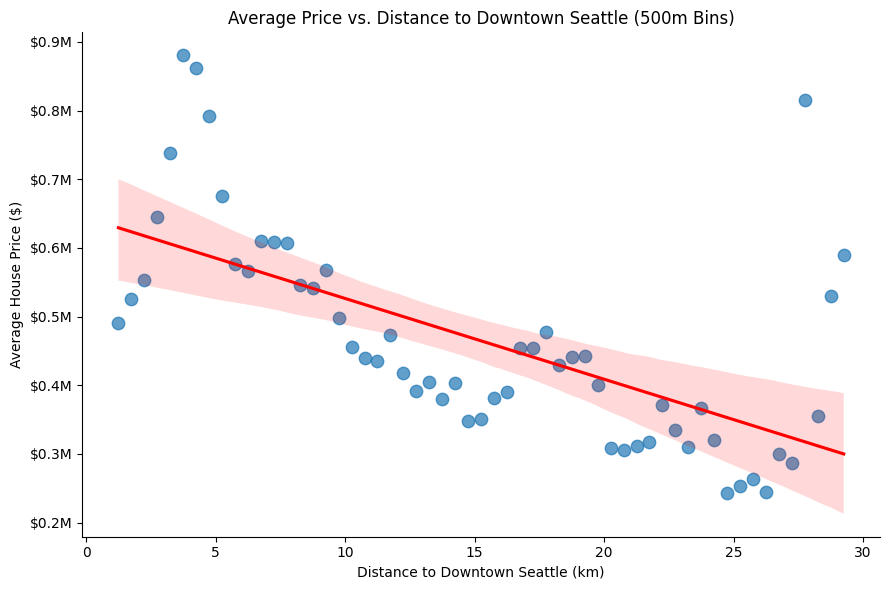

In [14]:
bin_edges = np.arange(
    0,
    df_joined_981['distance_to_downtown'].max() + 0.5,
    0.5
)

# Bin-Zuweisung
df_joined_981['distance_bin'] = pd.cut(
    df_psycopg['distance_to_downtown'],
    bins=bin_edges,
    include_lowest=True,
    right=False
)

df_bins = (
    df_joined_981.groupby('distance_bin')
    .agg({
        'price': 'mean'
    })
    .reset_index()
)

# Midpoint jeder Bin berechnen
df_bins['distance_mid'] = df_bins['distance_bin'].apply(lambda x: (x.left + x.right) / 2)

g = sns.lmplot(
    data=df_bins,
    x='distance_mid',
    y='price',
    height=6,
    aspect=1.5,
    scatter_kws={'s': 80, 'alpha': 0.7},
    line_kws={'color': 'red'}
)

ax = g.axes[0,0]

# Preis in Millionen-Format
formatter = FuncFormatter(lambda x, _: f'${x/1e6:.1f}M')
ax.yaxis.set_major_formatter(formatter)

# Titel & Achsen
ax.set_title('Average Price vs. Distance to Downtown Seattle (500m Bins)')
ax.set_xlabel('Distance to Downtown Seattle (km)')
ax.set_ylabel('Average House Price ($)')

plt.tight_layout()
plt.show()

In [15]:
map2 = px.scatter_mapbox(
    df_joined_981,
    lat='lat',
    lon='long',
    size_max=15,
    color='price',
    size=None,
    color_continuous_scale='viridis',
    zoom=10,
    mapbox_style='carto-positron',
    title='Price for house and location'
)
map2.update_layout(
    width=1400,
    height=900
)

map2.show()

/var/folders/lk/gq8wby6x3fv6n16s31xl4dg00000gn/T/ipykernel_1664/1764238716.py:1: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



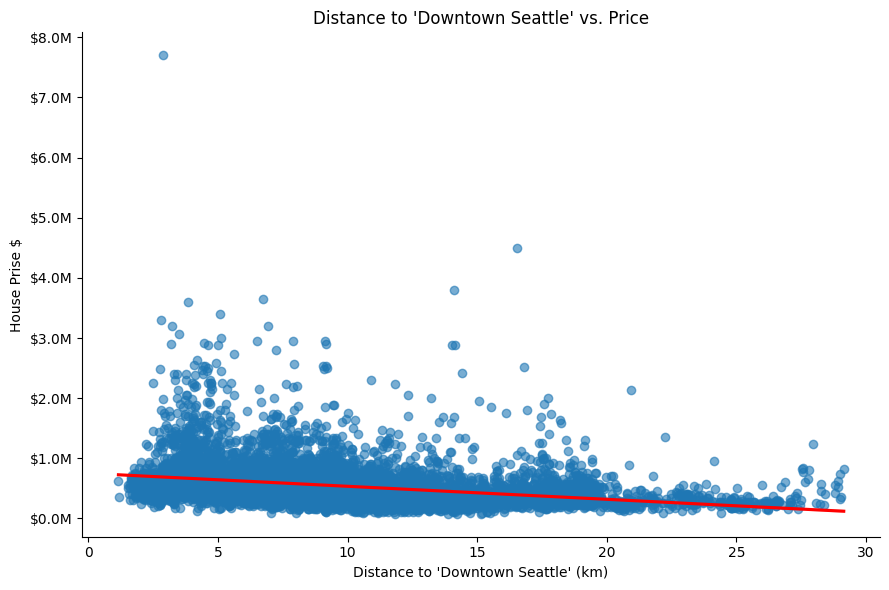

In [16]:
g2 = sns.lmplot(
    data=df_joined_981,
    x='distance_to_downtown',
    y='price',
    height=6,
    aspect=1.5,
    scatter_kws={'alpha':0.6},
    line_kws={'color':'red'}
)
ax = g2.axes[0,0]

# Formatter für Preis in Millionen $
formatter = FuncFormatter(lambda x, _: f'${x/1e6:.1f}M')
ax.yaxis.set_major_formatter(formatter)

# Achsentitel usw.
ax.set_title("Distance to 'Downtown Seattle' vs. Price")
ax.set_xlabel("Distance to 'Downtown Seattle' (km)")
ax.set_ylabel('House Prise $')

plt.tight_layout()
plt.show()

In [17]:
# Regression durchführen
result = linregress(df['distance_to_downtown'], df['price'])

# Steigung (pro km)
print(f"Steigung (pro km): {result.slope:.2f} $/km")

# Achsenabschnitt (Intercept)
print(f"Achsenabschnitt: {result.intercept:.2f}")

# p-Wert (Signifikanz)
print(f"p-Wert: {result.pvalue:.4f}")

# R² (Erklärte Varianz)
print(f"R²: {result.rvalue**2:.4f}")

NameError: name 'df' is not defined

In [ ]:
filter_client1 = df_joined_981[
    (df_joined_981['distance_to_downtown'] > 20) &
    (df_joined_981['distance_to_downtown'] < 30) &
    (df_joined_981['price'] >= 0) &
    (df_joined_981['price'] <= 300000)
]
client_properties_outskrit = filter_client1.sort_values('distance_to_downtown', ascending=False).head(10)[['zipcode', 'price', 'distance_to_downtown', 'lat', 'long']]


In [ ]:

print(client_properties_outskrit)
map3 = px.scatter_mapbox(
    client_properties_outskrit,
    lat='lat',
    lon='long',
    size_max=15,
    color='price',
    size=None,
    color_continuous_scale='viridis',
    zoom=13,
    mapbox_style='carto-positron',
    title='Price for house and location'
)
map3.update_layout(
    width=800,
    height=600
)

map3.show()

       zipcode     price  distance_to_downtown      lat     long
6474     98198  217000.0             28.368958  47.3500 -122.322
19605    98198  235000.0             28.235756  47.3514 -122.315
11780    98198  256000.0             28.091418  47.3527 -122.315
877      98198  229000.0             27.440486  47.3586 -122.314
12780    98198  149500.0             27.369760  47.3592 -122.315
4795     98198  227500.0             27.147722  47.3612 -122.315
12651    98198  278000.0             27.125759  47.3617 -122.308
16459    98198  269000.0             27.087070  47.3620 -122.309
3570     98198  230000.0             27.053800  47.3623 -122.309
5649     98198  152000.0             26.981616  47.3630 -122.308


/var/folders/lk/gq8wby6x3fv6n16s31xl4dg00000gn/T/ipykernel_69539/1379313438.py:2: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



In [ ]:
df_joined_981

In [ ]:
# Regression durchführen
result = linregress(df_joined_981['distance_to_downtown'], df_joined_981['price'])

# Steigung (pro km)
print(f"Steigung (pro km): {result.slope:.2f} $/km")

# Achsenabschnitt (Intercept)
print(f"Achsenabschnitt: {result.intercept:.2f}")

# p-Wert (Signifikanz)
print(f"p-Wert: {result.pvalue:.4f}")

# R² (Erklärte Varianz)
print(f"R²: {result.rvalue**2:.4f}")

Steigung (pro km): -21639.35 $/km
Achsenabschnitt: 751559.35
p-Wert: 0.0000
R²: 0.1000


In [ ]:
X = df_joined_981[['distance_to_downtown', 'sqft_living', 'sqft_lot']]
y = df_joined_981['price']

# Konstante Spalte für Intercept hinzufügen
X = sm.add_constant(X)

# Modell schätzen
model = sm.OLS(y, X).fit()

# Zusammenfassung anzeigen
print(model.summary())
print(model.pvalues)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     4622.
Date:                 Do, 10 Jul 2025   Prob (F-statistic):               0.00
Time:                        09:35:20   Log-Likelihood:            -1.2284e+05
No. Observations:                8973   AIC:                         2.457e+05
Df Residuals:                    8969   BIC:                         2.457e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.016e+05 

In [ ]:
X = df_joined_981[['distance_to_downtown', 'sqft_living', 'sqft_lot']]
X = sm.add_constant(X)
y = df_joined_981['price']

model = sm.OLS(y, X).fit()
print(model.pvalues)

const                   1.432306e-159
distance_to_downtown     0.000000e+00
sqft_living              0.000000e+00
sqft_lot                 6.262874e-24
dtype: float64


In [ ]:
result_tail_test = linregress(df_joined_981['distance_to_downtown'], df_joined_981['price'])
print(f"slope: {result.slope:.20f}")
print(f"p (two-tail): {result.pvalue:.20f}")

if result_tail_test.slope < 0:
    p_one_tailed = result_tail_test.pvalue / 2
    print(f"One-tail p-value (slope < 0): {p_one_tailed:.20f}")
else:
    print("Steigung ist nicht negativ → One-tail-Test in dieser Richtung nicht sinnvoll")

slope: -21639.35
p (two-tail): 0.00000000000000000000
One-tail p-value (slope < 0): 0.00000000000000000000


In [ ]:
df_joined_981.dtypes

id                         int64
bedrooms                 float64
bathrooms                float64
sqft_living              float64
sqft_lot                 float64
floors                   float64
waterfront               float64
view                     float64
condition                  int64
grade                      int64
sqft_above               float64
sqft_basement            float64
yr_built                   int64
yr_renovated             float64
zipcode                    int64
lat                      float64
long                     float64
sqft_living15            float64
sqft_lot15               float64
date                      object
price                    float64
house_id                   int64
id_2                       int64
distance_to_downtown     float64
distance_bin            category
zip_join                   int64
lat_zipcode              float64
lng_zipcode              float64
city                      object
state_id                  object
state_name

/var/folders/lk/gq8wby6x3fv6n16s31xl4dg00000gn/T/ipykernel_69539/3901523816.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




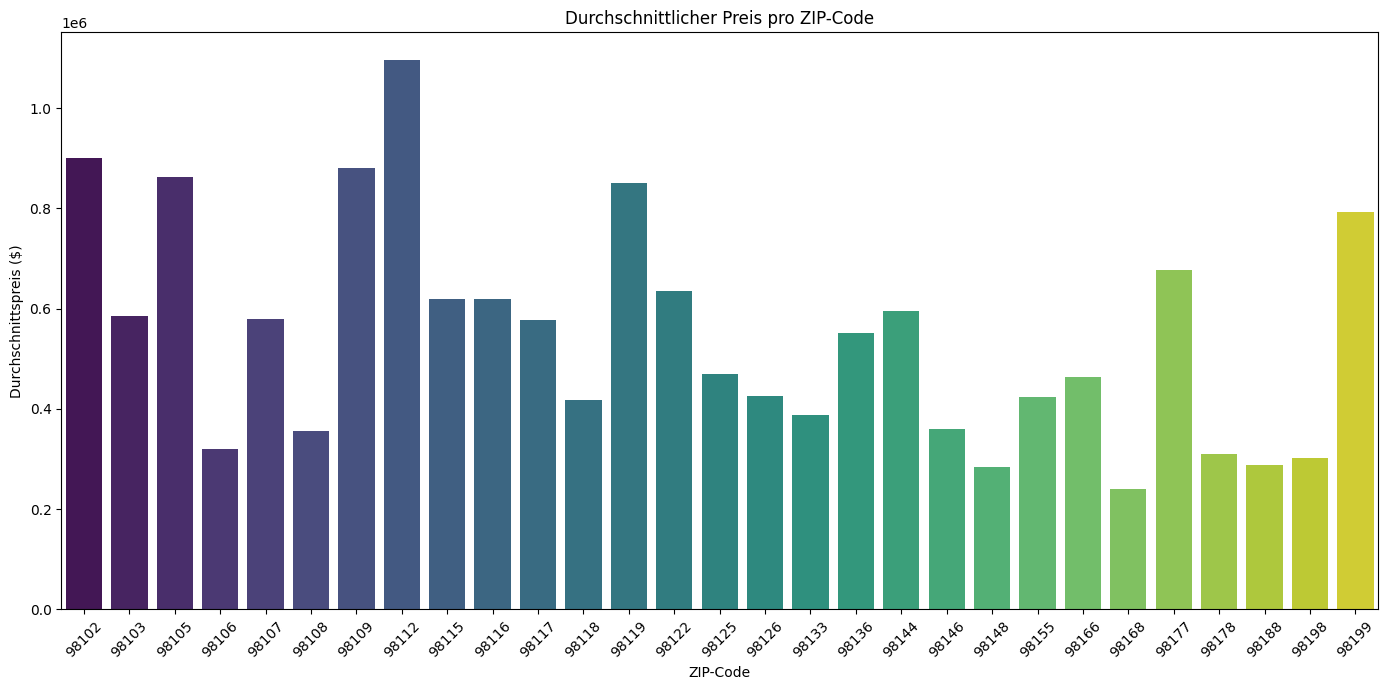

In [ ]:
df_zip_table = (
    df_joined_981.groupby(['zipcode', 'lat_zipcode', 'lng_zipcode'])['price']
    .mean()
    .round(2)
    .reset_index()
    .sort_values('price', ascending=False)
)
df_zip_table

plt.figure(figsize=(14, 7))

sns.barplot(
    data=df_zip_table,
    x='zipcode',
    y='price',
    palette='viridis'
)

plt.title('Durchschnittlicher Preis pro ZIP-Code')
plt.xlabel('ZIP-Code')
plt.ylabel('Durchschnittspreis ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

   zipcode  lat_zipcode  lng_zipcode      price  distance_to_downtown_zip
0    98122     47.60985   -122.29569  634558.14                  2.957483
1    98109     47.63128   -122.34486  880077.75                  3.023814
2    98102     47.63627   -122.32337  899607.67                  3.571066
3    98144     47.58582   -122.29205  594706.54                  3.832666
4    98119     47.63943   -122.36932  849714.81                  4.640552


/var/folders/lk/gq8wby6x3fv6n16s31xl4dg00000gn/T/ipykernel_69539/1827843931.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




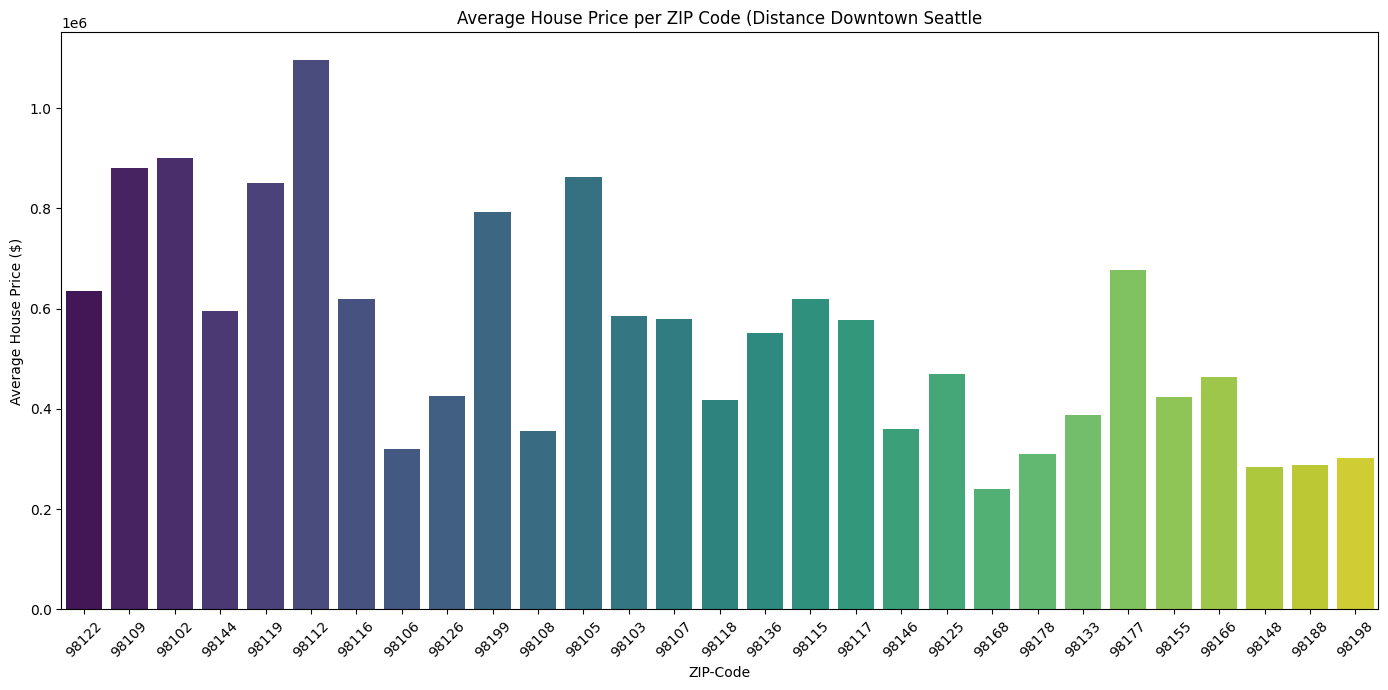

<bound method DataFrame.all of     zipcode  lat_zipcode  lng_zipcode       price  distance_to_downtown_zip
0     98122     47.60985   -122.29569   634558.14                  2.957483
1     98109     47.63128   -122.34486   880077.75                  3.023814
2     98102     47.63627   -122.32337   899607.67                  3.571066
3     98144     47.58582   -122.29205   594706.54                  3.832666
4     98119     47.63943   -122.36932   849714.81                  4.640552
5     98112     47.63242   -122.28732  1096239.01                  4.667765
6     98116     47.57399   -122.39503   618695.11                  5.720318
7     98106     47.54339   -122.35366   319581.39                  7.004606
8     98126     47.54732   -122.37454   424734.60                  7.091823
9     98199     47.65139   -122.40223   792187.87                  7.251752
10    98108     47.54113   -122.31260   355678.52                  7.290288
11    98105     47.66094   -122.28321   863228.94        

In [ ]:
downtown_center = (47.6050242, -122.3343709)

def calc_distance_zip_center(row):
    zip_center = (row['lat_zipcode'], row['lng_zipcode'])
    return geodesic(downtown_center, zip_center).km


df_zip_table['distance_to_downtown_zip'] = df_zip_table.apply(calc_distance_zip_center, axis=1)
df_zip_filtered = df_zip_table[df_zip_table['distance_to_downtown_zip'] > 15]

df_zip_table = df_zip_table.sort_values('distance_to_downtown_zip', ascending=True).reset_index(drop=True)
print(df_zip_table.head())

plt.figure(figsize=(14, 7))

sns.barplot(
    data=df_zip_table,
    x='zipcode',
    y='price',
    order=df_zip_table['zipcode'],  # Reihenfolge = sortiert nach Distanz
    palette='viridis'
)

plt.title('Average House Price per ZIP Code (Distance Downtown Seattle')
plt.xlabel('ZIP-Code')
plt.ylabel('Average House Price ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

df_zip_table.all

In [ ]:
df_joined_981[df_joined_981['zipcode'].astype(str).str.startswith('981')]['zipcode'].unique()

array([98178, 98125, 98136, 98198, 98146, 98115, 98107, 98126, 98103,
       98133, 98119, 98112, 98117, 98166, 98148, 98105, 98122, 98144,
       98116, 98118, 98199, 98102, 98108, 98168, 98177, 98109, 98155,
       98106, 98188])

/var/folders/lk/gq8wby6x3fv6n16s31xl4dg00000gn/T/ipykernel_69539/2109464863.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




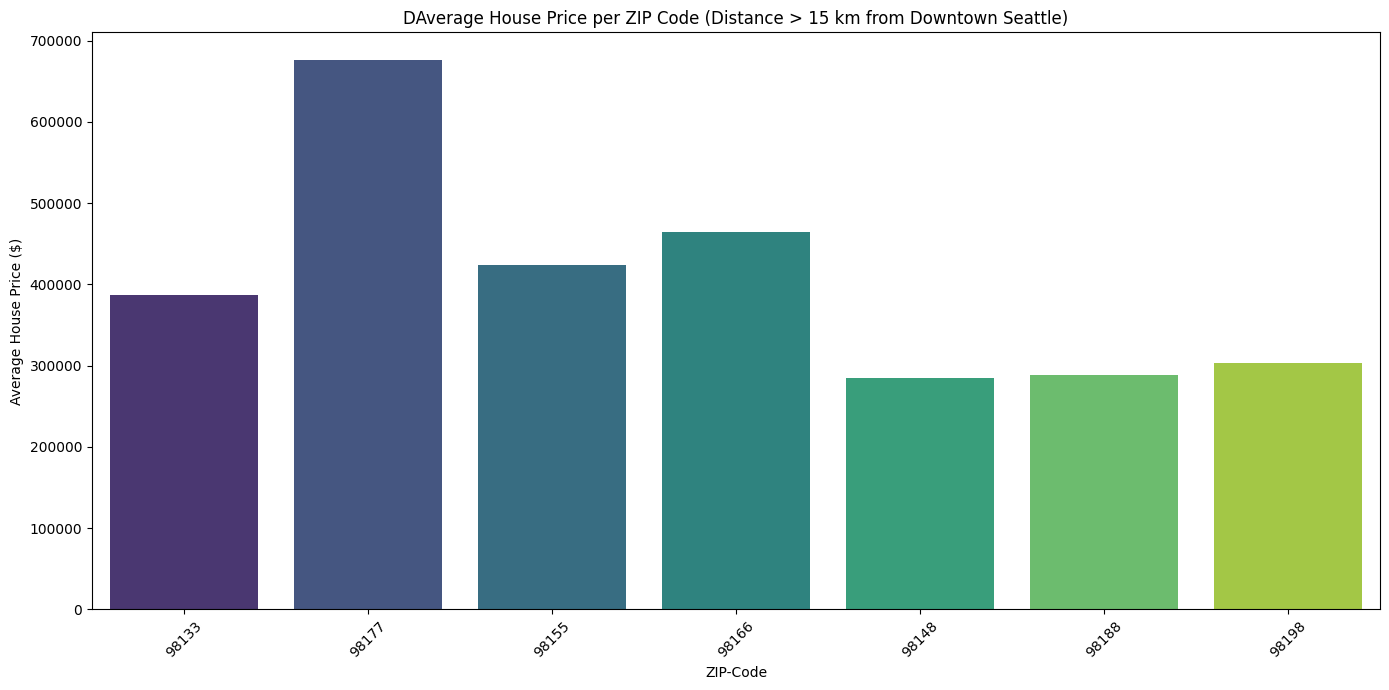

In [ ]:
plt.figure(figsize=(14, 7))

sns.barplot(
    data=df_zip_filtered,
    x='zipcode',
    y='price',
    order=df_zip_filtered.sort_values('distance_to_downtown_zip')['zipcode'],  # nach Distanz sortieren
    palette='viridis'
)

plt.title('DAverage House Price per ZIP Code (Distance > 15 km from Downtown Seattle)')
plt.xlabel('ZIP-Code')
plt.ylabel('Average House Price ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
filter_client3 = df_zip_filtered[
    (df_zip_filtered['distance_to_downtown_zip'] > 15)  &
    (df_zip_filtered['price'] >= 0) &
    (df_zip_filtered['price'] <= 350000)
]
client_properties_outskrit2 = filter_client3.sort_values('distance_to_downtown_zip', ascending=False).head(10)[['zipcode', 'price', 'distance_to_downtown_zip', 'lat_zipcode', 'lng_zipcode']]
print(client_properties_outskrit2)

    zipcode      price  distance_to_downtown_zip  lat_zipcode  lng_zipcode
28    98198  302896.74                 23.450659     47.39469   -122.31111
27    98188  289078.35                 18.090240     47.44754   -122.27398
26    98148  284908.60                 17.809843     47.44494   -122.32587


In [ ]:
filter_client5 = df_joined_981[
    (df_joined_981['distance_to_downtown'] > 15)  &
    (df_joined_981['price'] >= 0) &
    (df_joined_981['price'] <= 150000) &
    (df_joined_981['zipcode'] == 98198) &
    (df_joined_981['bedrooms'] > 2)
]
client_properties_outskrit5 = filter_client5.sort_values('distance_to_downtown', ascending=False).head(10)[['id','zipcode', 'price', 'distance_to_downtown', 'lat', 'long', 'bedrooms']]
print(client_properties_outskrit5)

               id  zipcode     price  distance_to_downtown      lat     long  \
12780  9536601996    98198  149500.0             27.369760  47.3592 -122.315   
10506  7888000400    98198  150000.0             26.233195  47.3697 -122.309   
1574   7888000390    98198  140000.0             26.211018  47.3699 -122.309   
1896   1697000400    98198  133000.0             25.773906  47.3737 -122.312   
4852   7138000170    98198  147500.0             23.281281  47.3970 -122.299   
3866   7893203565    98198  120000.0             20.673828  47.4191 -122.330   
4565   7686203275    98198  140000.0             20.573264  47.4204 -122.316   

       bedrooms  
12780       3.0  
10506       3.0  
1574        3.0  
1896        3.0  
4852        3.0  
3866        3.0  
4565        3.0  


In [ ]:
map5 = px.scatter_mapbox(
    client_properties_outskrit5,
    lat='lat',
    lon='long',
    size_max=200,
    color='price',
    size=None,
    color_continuous_scale='viridis',
    zoom=13,
    mapbox_style='carto-positron',
    title='Offers (98198), Seattle' 
)
map5.update_layout(
    width=400,
    height=900
)

map5.update_traces(marker=dict(size=30, opacity=0.8))

map5.show()

/var/folders/lk/gq8wby6x3fv6n16s31xl4dg00000gn/T/ipykernel_69539/1740274371.py:1: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

